In [ ]:
#| hide 
from nbdev.showdoc import *
from fastcore.utils import *

In [ ]:
import polars as pl
import numpy as np
import pandas as pd
import pycdfpp
import pyspedas

from sunpy.time import TimeRange

from loguru import logger
import os

In [ ]:
artemis_probes = ["b", "c"]
probe = artemis_probes[0]

jno_start_date = "2011-08-25"
jno_end_date = "2016-06-30" 

trange = TimeRange(jno_start_date, jno_end_date)
test_trange = TimeRange("2011-08-25", "2011-09-25")

In [ ]:
def convert_thm_state_to_parquet(
    probe: str, trange: TimeRange
):
    file_name = f"./data/th{probe}_state.parquet"
    if os.path.exists(file_name):
        return file_name

    start = trange.start.to_string()
    end = trange.end.to_string()

    files = pyspedas.themis.state(
        probe=probe,
        trange=[start, end],
        downloadonly=True,
        no_update=True,
    )

    thm_pos_sse_Xs = []
    thm_pos_gse_Xs = []
    thm_state_times = []
    for file in files:
        thm_state = pycdfpp.load(file)
        epoch_dt64 = thm_state[
            f"time"
        ].values  #  CATDESC: "thm_state_time, UTC, in seconds since 01-Jan-1970 00:00:00"
        thm_pos_sse_Xs.append(thm_state[f"th{probe}_pos_sse"].values[:, 0])
        thm_pos_gse_Xs.append(thm_state[f"th{probe}_pos_gse"].values[:, 0])
        thm_state_times.append(epoch_dt64)

    thm_pos_sse_X = np.concatenate(thm_pos_sse_Xs)
    thm_pos_gse_X = np.concatenate(thm_pos_gse_Xs)
    thm_state_time = np.concatenate(thm_state_times)

    pl.DataFrame(
        {
            "thm_state_time": thm_state_time,
            "thm_pos_gse_X": thm_pos_gse_X,
            "thm_pos_sse_X": thm_pos_sse_X,
        }
    ).with_columns(
        pl.from_epoch(pl.col("thm_state_time"), time_unit="s")
    ).write_parquet(
        file_name
    )

    return file_name


def convert_thm_fgm_to_parquet(probe, trange):
    file_name = f"./data/th{probe}_fgm.parquet"
    if os.path.exists(file_name):
        return file_name

    start = trange.start.to_string()
    end = trange.end.to_string()
    
    files = pyspedas.themis.fgm(
        probe=probe,
        trange=[start, end],
        downloadonly=True,
        no_update=True,
    )

    thm_fgl_gses = []
    thm_fgl_btotals = []
    thm_fgl_times = []

    for file in files:
        cdf = pycdfpp.load(file)
        thm_fgl_gses.append(cdf[f"th{probe}_fgl_gse"].values)
        thm_fgl_btotals.append(cdf[f"th{probe}_fgl_btotal"].values)
        thm_fgl_times.append(cdf[f"th{probe}_fgl_time"].values)

    thm_fgl_gse = np.concatenate(thm_fgl_gses)
    thm_fgl_btotal = np.concatenate(thm_fgl_btotals)
    thm_fgl_time = np.concatenate(thm_fgl_times)

    pl.DataFrame(
        {
            "time": thm_fgl_time,
            "BX": thm_fgl_gse[:,0],
            "BY": thm_fgl_gse[:,1],
            "BZ": thm_fgl_gse[:,2],
            "B": thm_fgl_btotal,
        }
    ).with_columns(
        pl.from_epoch(pl.col("thm_fgl_time"), time_unit="s"),
    ).write_parquet(   
        file_name
    )
    
    return file_name

In [ ]:
convert_thm_state_to_parquet(probe, trange)
convert_thm_fgm_to_parquet(probe, trange)

21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: Searching for local files...
21-Sep-23 11:21:25: 

KeyboardInterrupt: 

In [ ]:
import speasy as spz

In [ ]:
def download_data(product, trange):
    logger.info("Downloading data")
    start_time = trange.start.to_string()
    stop_time = trange.end.to_string()
    spz.get_data(product, start_time, stop_time)
    logger.info("Data downloaded")
    # spz.get_data(products, jno_start_date, jno_end_date)    

In [ ]:
# Download data in a background thread
import threading, time

products = spz.inventories.data_tree.cda.THEMIS.THB.L2.THB_L2_FGM.thb_fgs_gse
# Create a thread and start it
thread = threading.Thread(target=download_data, args=(products, trange))
thread.start()

Doing oer stuff


In [ ]:
from datetime import timedelta

tau = timedelta(seconds=30)

index_std_threshold = 2
index_fluc_threshold = 1
index_diff_threshold = 0.1

data_resolution = timedelta(seconds=4)
sparse_num = (tau / data_resolution) - 2 



filter_condition = (
    (pl.col("index_std") > index_std_threshold)
    & (pl.col("index_fluctuation") > index_fluc_threshold)
    & (pl.col("index_diff") > index_diff_threshold)
    & (
        pl.col("index_std").is_finite()
    )  # for cases where neighboring groups have std=0
    & (
        pl.col("count") > sparse_num
    )  # filter out sparse intervals, which may give unreasonable results.
)

In [ ]:

import os

file_name = "./data/thb_fgs_gse.parquet"

if os.path.exists(file_name):
    logger.info("Reading data from parquet")
    df = pl.scan_parquet(file_name).set_sorted('time')
else:
    data = spz.get_data(products, trange.start.datetime, trange.end.datetime)
    df = pl.DataFrame(
        {
            "BX": data.values[:, 0],
            "BY": data.values[:, 1],
            "BZ": data.values[:, 2],
            "time": data.time,
        }
    ).sort("time")
    df.write_parquet(file_name)

2023-09-19 13:05:08.775 | INFO     | __main__:<cell line: 5>:6 - Reading data from parquet


In [ ]:
from ids_finder.utils import *

indices = compute_indices(df, tau)
candidates_pl = indices.filter(filter_condition).with_columns(pl_format_time(tau))

In [ ]:
candidates = candidates_pl.to_pandas()

In [ ]:
logger.info(f"Number of candidates to process: {len(candidates)}")

2023-09-19 13:12:12.756 | INFO     | __main__:<cell line: 1>:1 - Number of candidates to process: 274742


In [ ]:
pl.scan_parquet(convert_thm_state_to_parquet(probe, trange)).filter(
    (pl.col("thm_pos_gse_X") > 0) & (pl.col("thm_pos_sse_X") > 0)
).collect().shape

(653726, 3)

18-Sep-23 16:06:52: File is current: /Users/zijin/data/themis/thb/l1/state/2013/thb_l1_state_20131105.cdf


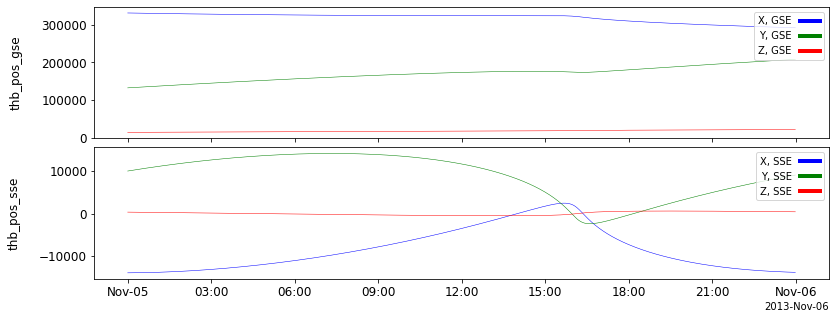

In [ ]:
import pyspedas
from pytplot import tplot

# from pytplot import tplot
state_vars = pyspedas.themis.state(
    probe="b", trange=[jno_start_date, jno_end_date], downloadonly=True
)
# tplot(['thb_pos_gse', 'thb_pos_sse'])

In [ ]:
state_vars

['thb_pos',
 'thb_vel',
 'thb_spin_initial_delta_phi',
 'thb_spin_idpu_spinper',
 'thb_spin_segflags',
 'thb_spin_ecl_initial_delta_phi',
 'thb_spin_ecl_idpu_spinper',
 'thb_spin_ecl_segflags',
 'thb_pos_gse',
 'thb_pos_gsm',
 'thb_vel_gse',
 'thb_vel_gsm',
 'thb_pos_sel',
 'thb_pos_sse',
 'thb_vel_sel',
 'thb_vel_sse']